# Water detection with Sentinel-1

* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc)

## Description 
In this example, we access Digital Earth Africa Sentinel-1 data in AWS SageMaker. We use this data to carry out water detection analysis based on Digital Earth Africa’s existing [Water Detection with Sentinel-1 notebook](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Real_world_examples/Radar_water_detection.html).

The notebook contains the following steps:

1. Importing required packages for loading data and analysis
2. Access Sentinel-1 analysis ready data from Digital Earth Africa
3. Visualise data and export a multi-band, single time-slice GeoTIFF
4. Applying speckle filter and converting the digital numbers to dB values for analysis
5. Use histogram analysis to determine the threshold for water classification
6. Design a classifier to distinguish land and water
7. Apply the classifier to the area of interest and interpret the results

## Load packages for accessing data

In [1]:
# import required packages
from pystac_client import Client
from odc.stac import stac_load, configure_rio

## Set Collection Configuration
The configuration dictionary is determined from the product’s definition, available at https://explorer.digitalearth.africa/products/s1_rtc


In [2]:
# VV, VH, AREA = NaN, float32
# angle = 255, uint8
# mask = 0, uint8

# set the collection configuration, setting the products definition 
config = {
    "s1_rtc": {
        "assets": {
            "*": {
                "data_type": "float32",
                "nodata": float('nan'),
                "unit": "1",
            },
            "angle": {
                "data_type": "uint8",
                "nodata": 255,
                "unit": "1",
            },
            "mask": {
                "data_type": "uint8",
                "nodata": 0,
                "unit": "1",
            },
        },
    }
}

## Set AWS Configuration

Digital Earth Africa data is stored on S3 in Cape Town, Africa. To load the data, we must configure rasterio with the appropriate AWS S3 endpoint. This is done with the odc.stac.configure_rio function.

The configuration below must be used when loading any Digital Earth Africa data through the STAC API.

In [3]:
# set AWS configuration with specific endpoint
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

In [4]:
# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")
catalog

<Client id=DEAfrica_data>

## Define Query Parameters

In [5]:
# Set a bounding box
# [xmin, ymin, xmax, ymax]
bbox = [-16.34, 12.5699, -16.24, 12.67]

# timeframe
single_date = "2020"

# Set the STAC collections
collections = ["s1_rtc"]

## Construct query and get items from catalog

In [6]:
# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime= single_date
)

# Search the STAC catalog for all items matching the query
items = list(query.get_items())
print(f"Found: {len(items):d} datasets")
print(items)

Found: 31 datasets
[<Item id=e4d1c5bb-849a-58b6-bd3d-6944b51b879e>, <Item id=152d23bd-a9b9-5c82-b6b3-5ef6f1a73fa3>, <Item id=fdddf3b0-f317-5d2a-a058-60037da0193c>, <Item id=5a3e99c7-be5d-5903-b269-18fc9edea24b>, <Item id=5351e89f-f32a-5927-afe9-020730089b26>, <Item id=52a080fa-b8b1-5f5d-858f-862915eab1ac>, <Item id=3296b299-0ec7-56f8-9044-435d54c47939>, <Item id=e8b00146-cd33-5071-a335-19bc3bbc8524>, <Item id=0623c8ae-3eaa-500e-9230-3fb08346c962>, <Item id=c09f392e-e21c-5e48-ad99-9626a8cf6471>, <Item id=24bf1696-7d1b-5a9d-80fb-9b2404b3cb25>, <Item id=a646def0-b8fd-51f1-9f8d-a10f670d0a9f>, <Item id=607f3199-c3d9-516c-bdad-ccdfde1941da>, <Item id=a38e67ba-1877-5a05-b92b-2a06a01c133f>, <Item id=b18c18de-7f62-54bc-8008-65bda7b749dc>, <Item id=3960bc42-67e9-5878-8ebe-2d85963eecc0>, <Item id=91222481-1309-5596-a820-1f6d51a4306b>, <Item id=2348fafd-9217-5bb9-ae81-682d73718a64>, <Item id=bab17ef4-991f-5de8-a31b-8af89c35abe8>, <Item id=67618b30-281a-5174-975d-6997a828f0e4>, <Item id=d9a34504-95

## Load the Data 

In this section we will use the `stac_load` function to only load data within the defined parameters set above. 

This data will be lazy-loaded with dask, meaning the it will not be loaded into memory until required, such as when it is displayed. 

In [7]:
crs = "EPSG:6933"
resolution = 20

ds = stac_load(
    items,
    bands= ["vv", "vh"],
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config,
    bbox=bbox
)

# View the Xarray Dataset - loads as dask array 
ds

/home/studio-lab-user/.conda/envs/dea-only/lib/python3.10/site-packages/odc/geo/geom.py:557: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type in ["Point", "MultiPoint"]:
/home/studio-lab-user/.conda/envs/dea-only/lib/python3.10/site-packages/odc/geo/geom.py:560: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type in ["GeometryCollection", "MultiPolygon", "MultiLineString"]:
/home/studio-lab-user/.conda/envs/dea-only/lib/python3.10/site-packages/odc/geo/geom.py:563: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type in ["LineString", "LinearRing"]:
/home/studio-lab-user/.conda/envs/dea-only/lib/python3.10/site-packages/odc/geo/geom.py:566: ShapelyDeprecationWarning

<xarray.Dataset>
Dimensions:      (y: 624, x: 484, time: 31)
Coordinates:
  * y            (y) float64 1.604e+06 1.604e+06 ... 1.591e+06 1.591e+06
  * x            (x) float64 -1.577e+06 -1.577e+06 ... -1.567e+06 -1.567e+06
    spatial_ref  int32 6933
  * time         (time) datetime64[ns] 2020-01-04T19:17:34.083167 ... 2020-12...
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 624, 484), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 624, 484), meta=np.ndarray>

Up until now we have used packages from `pystac_client` and `odc.stac` to access DE Africa data in SageMaker. The data has been loaded into a `dask.array` and from here we can now analyse the data using DE Africa `Tools` package. 

## Load packages for analysis

In [8]:
# import Python packages 
%matplotlib inline

import warnings 
import datacube
import numpy as np
import xarray as xarray
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.filters import threshold_minimum

from datacube.utils.cog import write_cog

# DEA tools 
from deafrica_tools.plotting import display_map, rgb

## Visualise the time series

In [9]:
# Selecting a few images from the loaded S1 to visualise 
timesteps = [2,4,6,9,11]

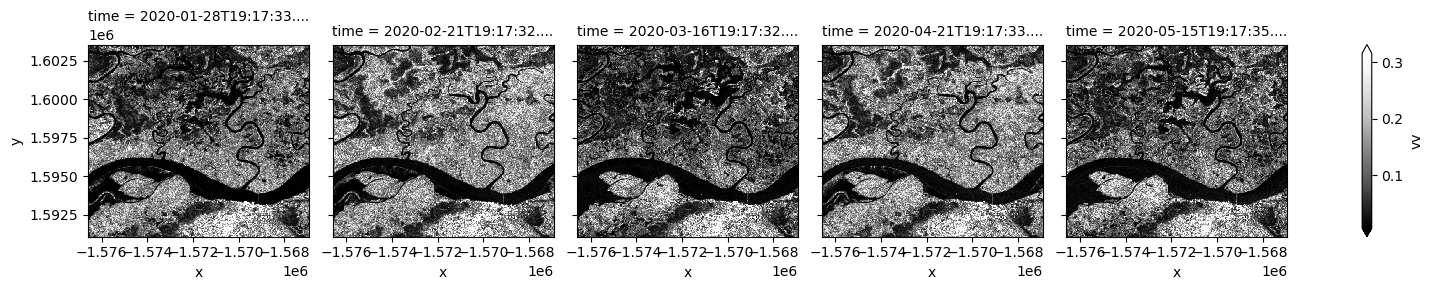

In [10]:
# Plot VV polarisation for specific timeframe 
ds.vv.isel(time=timesteps).plot(cmap="Greys_r", robust=True, col="time", col_wrap=5);

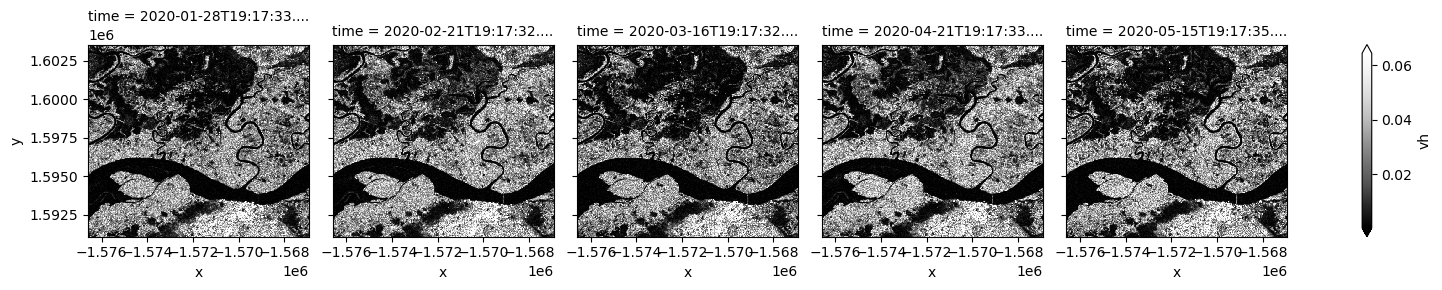

In [11]:
# Plot VH polarisation for specific timeframe 
ds.vh.isel(time=timesteps).plot(cmap="Greys_r", robust=True, col="time", col_wrap=5);

For the RGB visualization below, the ratio between VH and VV is added as a third measurement band.

In [12]:
# VH/VV is a potentially useful third feature after VV and VH 
ds['vh/vv'] = ds.vh/ds.vv

In [13]:
# load values to copy of ds using .compute()
data = ds.compute()

In [14]:
# median values are used to scale the measurements so they have a similar range for visualization
med_s1 = data.median()

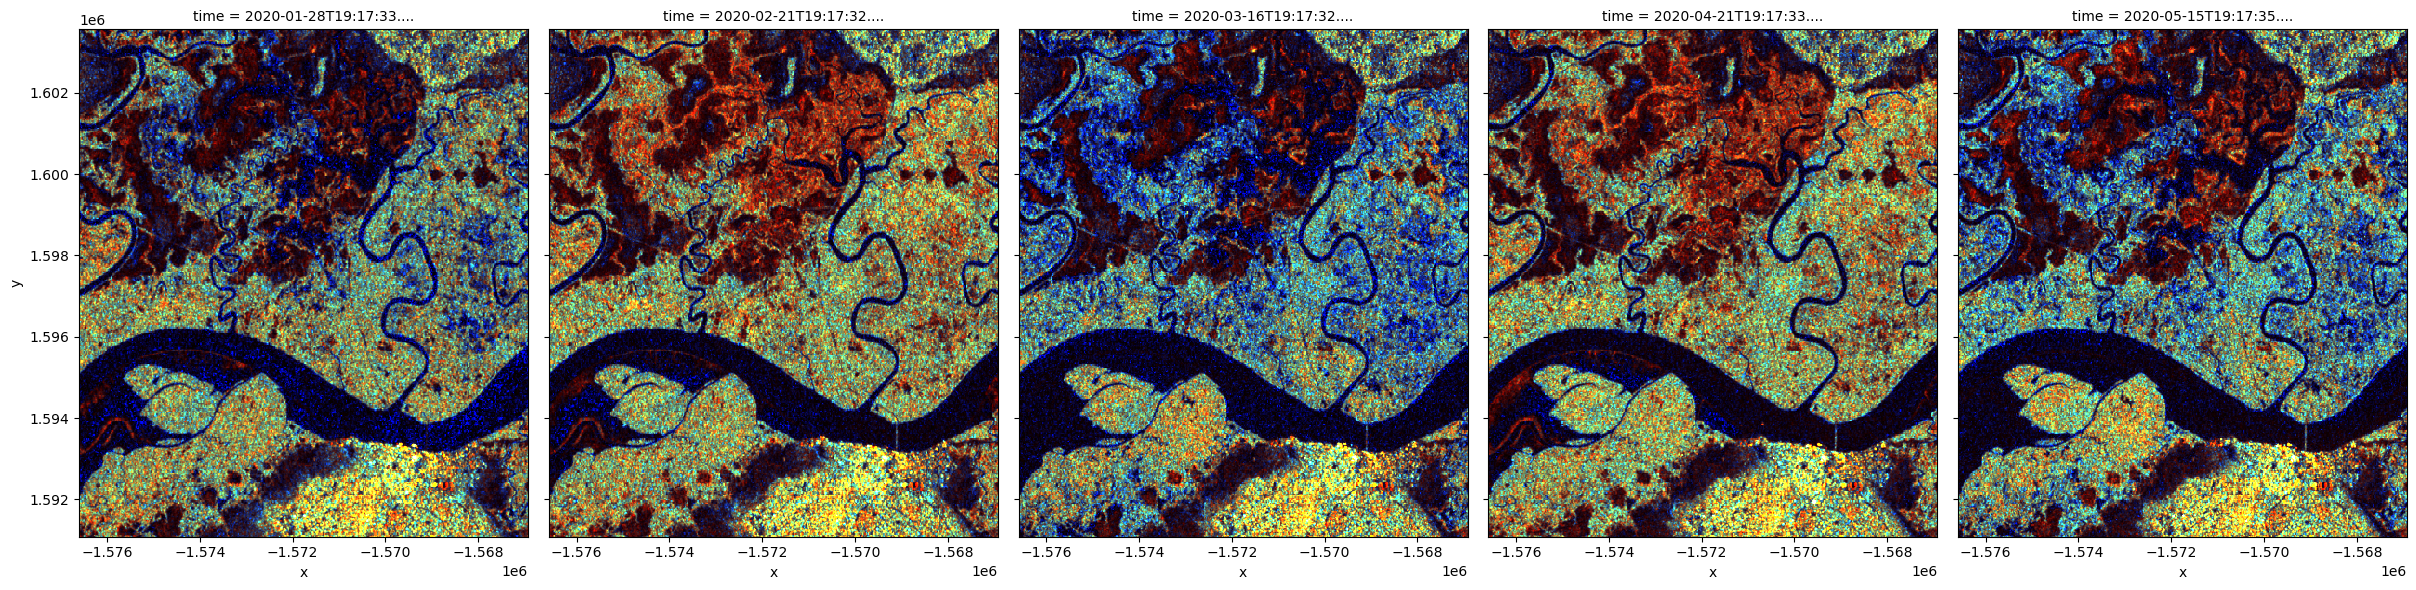

In [15]:
# plotting an RGB image for selected timesteps
rgb(data[['vv', 'vh', 'vh/vv']]/med_s1, bands=['vv',
    'vh', 'vh/vv'], index=timesteps, col_wrap=5);

## Exporting a multi-band, single time-slice GeoTIFF

In [16]:
da = data.to_array()

In [17]:
rgb_ga = da.isel(time=0)

In [18]:
write_cog(geo_im=rgb_ga,
         fname='rgb.tif',
         overwrite=True)

PosixPath('rgb.tif')

## Apply speckle filtering 

In [19]:
#defining a function to apply lee filtering on S1 image 
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    
    return img_output

In [20]:
# The lee filter above doesn't handle null values
# We therefore set null values to 0 before applying the filter
valid = data.where(~np.isinf(data))
data = data.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
data["filtered_vv"] = data.vv.groupby("time").apply(lee_filter, size=7)
data["filtered_vh"] = data.vh.groupby("time").apply(lee_filter, size=7)

# Null pixels should remain null
data['filtered_vv'] = data.filtered_vv.where(valid.vv, np.nan)
data['filtered_vh'] = data.filtered_vh.where(valid.vh, np.nan)

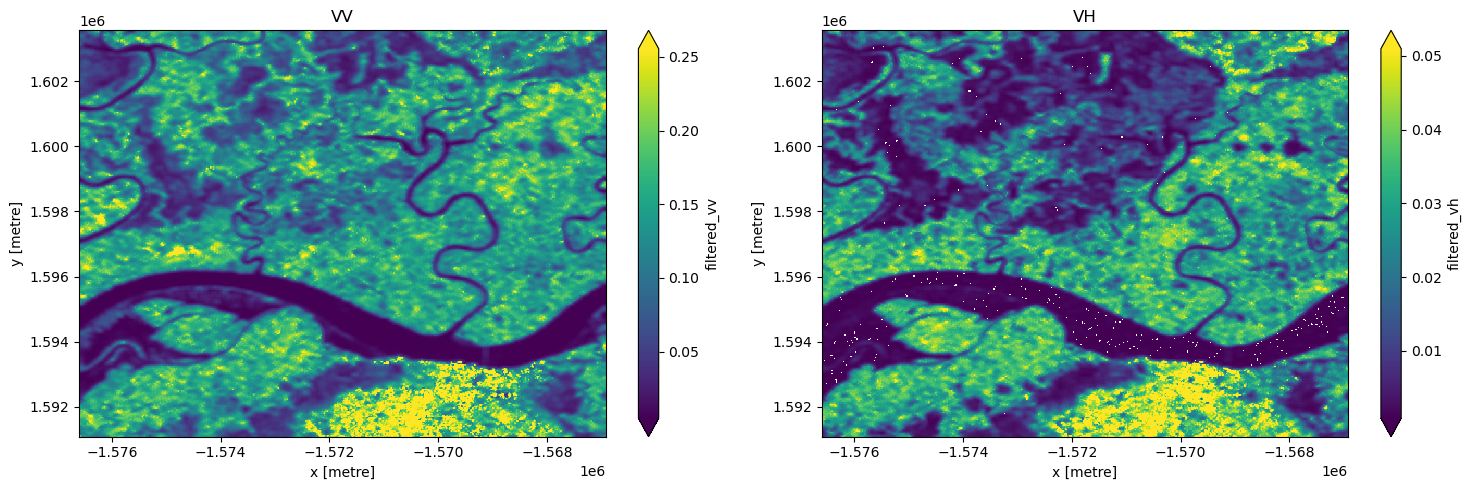

In [21]:
# images appear smoother after speckle filtering
fig, ax = plt.subplots(1, 2, figsize=(15,5))
data["filtered_vv"].isel(time=3).plot(ax = ax[0],robust=True)
data["filtered_vh"].isel(time=3).plot(ax = ax[1],robust=True);
ax[0].set_title('VV')
ax[1].set_title('VH')
plt.tight_layout();

In [22]:
# convert digital numbers to dB
data['filtered_vv'] = 10 * np.log10(data.filtered_vv)
data['filtered_vh'] = 10 * np.log10(data.filtered_vh)

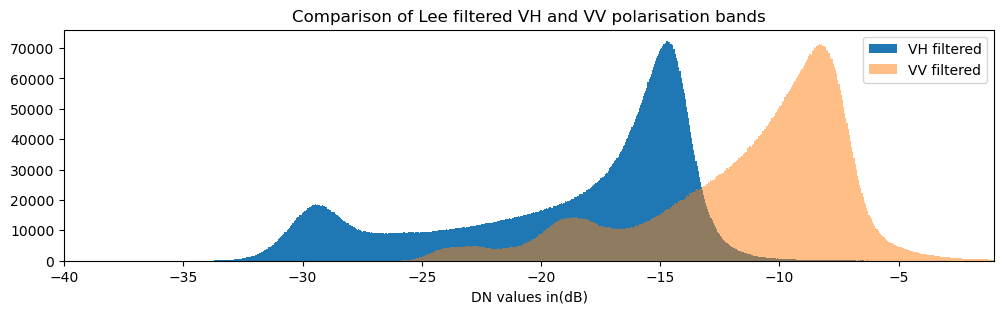

In [23]:
# histogram analysis for S1
fig = plt.figure(figsize=(12, 3))
data.filtered_vh.plot.hist(bins=1000, label="VH filtered")
data.filtered_vv.plot.hist(bins=1000, label="VV filtered",alpha=0.5)
plt.xlim(-40,-1)
plt.legend()
plt.xlabel("DN values in(dB)")
plt.title("Comparison of Lee filtered VH and VV polarisation bands");

## Build and apply the water classifier

In [24]:
vh_new = data['filtered_vh'].values
vh_new = vh_new[~np.isnan(vh_new)]

threshold_vh = threshold_minimum(vh_new)

print(threshold_vh)

-25.661585


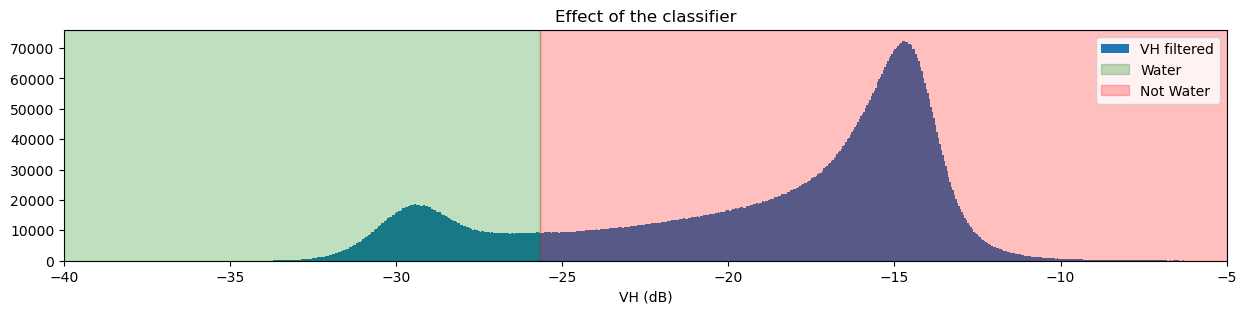

In [25]:
# visualise the threshold
fig, ax = plt.subplots(figsize=(15, 3))
data.filtered_vh.plot.hist(bins=1000, label="VH filtered")
plt.xlim(-40,-5)
ax.axvspan(xmin=-40.0, xmax=threshold_vh, alpha=0.25, color="green", label="Water")
ax.axvspan(xmin=threshold_vh,
           xmax=-5,
           alpha=0.25,
           color="red",
           label="Not Water")
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Effect of the classifier")
plt.show()

In [26]:
# define the classifier, values lower than the threshold are water pixels, return dataset containing water pixels 
def S1_water_classifier(da, threshold=threshold_vh):
    water_data_array = da < threshold
    return water_data_array.to_dataset(name="s1_water")

In [27]:
# return classified data product
data['water'] = S1_water_classifier(data.filtered_vh).s1_water
data

<xarray.Dataset>
Dimensions:      (time: 31, y: 624, x: 484)
Coordinates:
  * y            (y) float64 1.604e+06 1.604e+06 ... 1.591e+06 1.591e+06
  * x            (x) float64 -1.577e+06 -1.577e+06 ... -1.567e+06 -1.567e+06
    spatial_ref  int32 6933
  * time         (time) datetime64[ns] 2020-01-04T19:17:34.083167 ... 2020-12...
Data variables:
    vv           (time, y, x) float32 0.05976 0.04359 0.02704 ... 0.2923 0.1862
    vh           (time, y, x) float32 0.005369 0.004237 ... 0.01821 0.01918
    vh/vv        (time, y, x) float32 0.08984 0.09722 0.1888 ... 0.06229 0.103
    filtered_vv  (time, y, x) float32 -12.21 -12.32 -12.53 ... -7.404 -7.758
    filtered_vh  (time, y, x) float32 -22.11 -22.5 -22.74 ... -19.43 -19.19
    water        (time, y, x) bool False False False False ... False False False

## Assessment with mean 

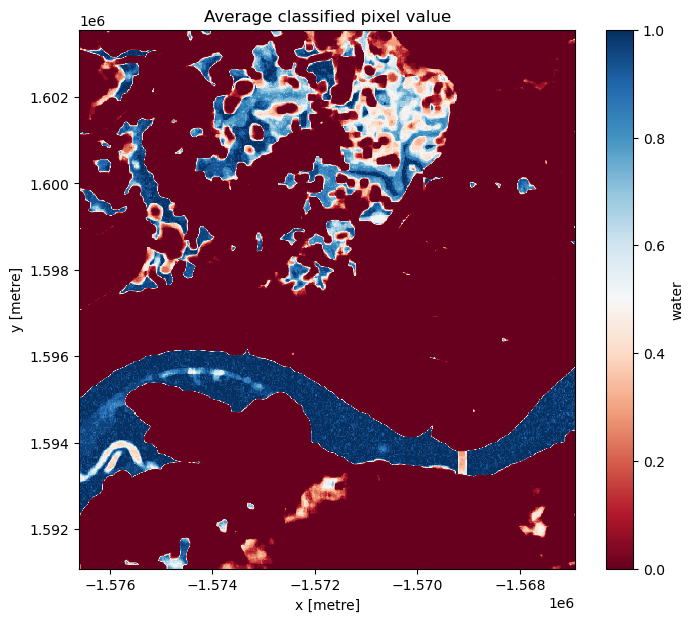

In [28]:
# Plot the mean of each classified pixel value
plt.figure(figsize=(8, 7))
data.water.mean(dim='time').plot(cmap="RdBu")
plt.title("Average classified pixel value");

## Assessment with standard deviation

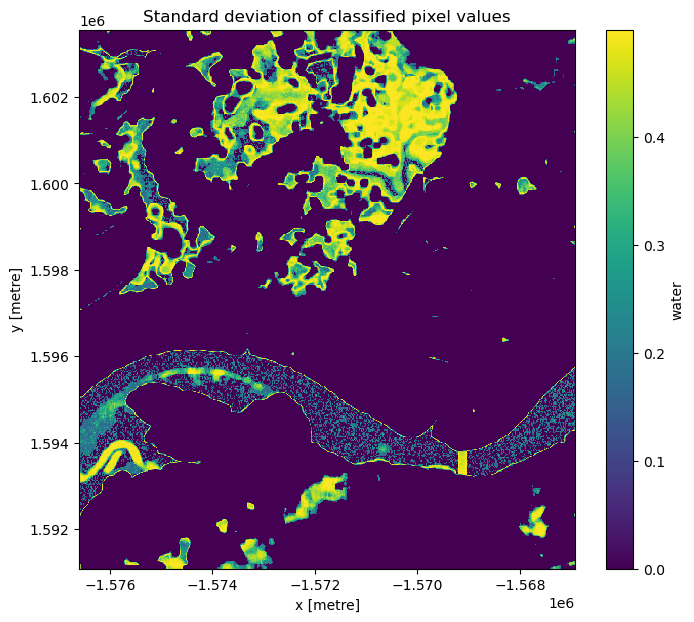

In [29]:
plt.figure(figsize=(8, 7))
data.water.std(dim="time").plot(cmap="viridis")
plt.title("Standard deviation of classified pixel values");